<a href="https://colab.research.google.com/github/AlbaPerezVilla/Bootcamp-IA/blob/main/sprint3_LAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1) Vemos si tenemos GPU
!nvidia-smi

# 2) Limpiamos los paquetes que suelen dar conflicto en Colab, ya que Colab ya trae cierto paquetes instalados
%pip uninstall -y torch torchvision torchaudio xformers pillow-simd

# 3) Instalamos PyTorch + TorchVision + TorchAudio ALINEADOS (familia 2.9/0.24/2.9)
%pip install -U --no-cache-dir --index-url https://download.pytorch.org/whl/cu126 \
  torch==2.9.0 torchvision==0.24.0 torchaudio==2.9.0

# 4) Instalamos librería transformers necesaria para poder utilizar stable diffusion
%pip install -U --no-cache-dir "transformers>=4.44,<5" diffusers==0.30.0 accelerate pillow

# 5) Reiniciamos el runtime (obligatorio en Colab tras cambiar PyTorch)
import IPython, sys
IPython.Application.instance().kernel.do_shutdown(True)


Fri Nov  7 18:53:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 132.9 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C


Verificación de instalación

Importamos las librerías necesarias y comprobamos que las versiones estén alineadas

In [1]:
import torch, torchvision, transformers
print("torch:", torch.__version__, "| CUDA runtime:", torch.version.cuda, "| cuda.is_available:", torch.cuda.is_available())
print("torchvision:", torchvision.__version__)
print("transformers:", transformers.__version__)

# Comprueba que existe la op NMS (común fuente de error)
from torchvision.ops import nms
print("torchvision.ops.nms OK")

# Comprueba que carga CLIPImageProcessor y está accesible desde transformers (transformers >= 4.44)
from transformers import CLIPImageProcessor
print("CLIPImageProcessor OK")

torch: 2.9.0+cu126 | CUDA runtime: 12.6 | cuda.is_available: True
torchvision: 0.24.0+cu126
transformers: 4.57.1
torchvision.ops.nms OK
CLIPImageProcessor OK


Importamos utilidades estándar para la cuadrícula, la anotación y el pipeline

In [2]:
from typing import List, Optional, Tuple
from PIL import Image, ImageDraw, ImageFont
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch, json, os, math, random
from datetime import datetime

Definición de cuadrícula

In [3]:
def image_grid(images: List[Image.Image], rows: int, cols: int,
               padding: int = 10, bg=(245,245,245)) -> Image.Image:
    # Verifica que hay el número correcto de imágenes.
    assert len(images) == rows * cols, "rows*cols debe coincidir con la cantidad de imágenes"
    # Obtiene el tamaño correcto de cada imagen
    w, h = images[0].size
    # Calcula el tamaño total de la cuadrícula
    W = cols*w + (cols+1)*padding
    H = rows*h + (rows+1)*padding
    # crea una nueva imagen vacía (de fondo gris)
    grid = Image.new("RGB", (W, H), color=bg)
    #"Pega" las imágenes de una en una en la cuadrícula
    k = 0
    for r in range(rows):
        for c in range(cols):
            x = padding + c*(w+padding)
            y = padding + r*(h+padding)
            grid.paste(images[k], (x, y))
            k += 1
    return grid

Definición de pie de imagen (semilla, pasos, et.) sobre cada imagen

In [4]:
def annotate(img: Image.Image, text: str, margin: int = 8) -> Image.Image:
    """Añade una pequeña anotación en la esquina inferior-izquierda (semilla/steps/cfg)."""
    im = img.copy() # Crea una copia para no modificar la original
    draw = ImageDraw.Draw(im)
    # Usa una fuente legible
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 18)
    except Exception:
        font = ImageFont.load_default()
    # Sombra
    draw.text((margin+1, im.height - 24 - margin+1), text, fill=(0,0,0), font=font)
    # Texto
    draw.text((margin, im.height - 24 - margin), text, fill=(255,255,255), font=font)
    return im

Definición de pipeline

In [5]:
def build_pipeline(model_id: str = "runwayml/stable-diffusion-v1-5",
                   device: str = "cuda") -> StableDiffusionPipeline:
    # Si hay GPU, usamos half precision (float16) para ahorrar VRAM
    dtype = torch.float16 if device == "cuda" else torch.float32
    # Carga el modelo preentrenado desde hugging face
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=dtype,
    )
    # Usa un scheduler (optimizador de pasos de difusión) más estable
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

    # Si hay GPU disponible, mueve el modelo a CUDA
    if device == "cuda" and torch.cuda.is_available():
        pipe.to(device)
        try:
            pipe.enable_xformers_memory_efficient_attention()
        except Exception:
            pass
        pipe.enable_attention_slicing()
        pipe.enable_vae_slicing()
    else:
      # Si no hay GPU, usa offloading en CPU (más lento)
        try:
            pipe.enable_model_cpu_offload()
        except Exception:
            pass
        pipe.enable_attention_slicing()
        pipe.enable_vae_slicing()

    return pipe

Generación de parámetros: definición de prompt y negative

In [12]:
PROMPT = "a field of wildflowers at sunrise, cinematic lighting, ultra realistic, depth of field, 4k photograph"
NEGATIVE = "blurry, low quality, painting, cartoon, people, text, watermark, logo"

NUM_IMAGES = 4        # Debe ser rows*cols, canidad total de imagenes a generar
ROWS, COLS = 2, 2     # Disposición del grid
HEIGHT, WIDTH = 512, 512  # Resolución de cada imagen

STEPS = 28            # pasos base de inferencia
GUIDANCE = 7.5        # cfg base (Controla la fidelidad al prompt)
JITTER_GUIDANCE = 0.8 # variación aleatoria sobre GUIDANCE
JITTER_STEPS = 6      # variación aleatoria sobre STEPS

MODEL_ID = "runwayml/stable-diffusion-v1-5" # Modelo base
OUTDIR = "/content/outputs" # Carpeto donde se guardan las imágenes
ANNOTATE_TILES = True # pone semilla/steps/cfg sobre cada tile
SEED_BASE = None      # Se genera aleatoriamente

Configuración inicial

In [13]:
os.makedirs(OUTDIR, exist_ok=True) # Crea la carpeta de salida si no existe
ts = datetime.now().strftime("%Y%m%d_%H%M%S") # Timestamp para nombres únicos
prefix = f"sd_{ts}" #prefijo para los archivos

device = "cuda" if torch.cuda.is_available() else "cpu" # detecta si hay gpu
pipe = build_pipeline(MODEL_ID, device=device) # crea pipeline lista para uso

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Creación de semillas

In [14]:
if SEED_BASE is None:
    SEED_BASE = int(torch.seed() % (2**31-1))     # Si no hay semilla base, se crea una
rng_base = torch.Generator().manual_seed(SEED_BASE)
# Crea una semilla diferente por cada imagen (para generar variaciones)
seeds = [int(torch.randint(0, 2**31 - 1, (1,), generator=rng_base)) for _ in range(NUM_IMAGES)]

Generación de las imágenes

In [15]:
images = []
meta_per_image = []

for i in range(NUM_IMAGES):
    # Introducimos pequeñas variaciones (jitter) para que las imágenes no sean idénticas
    g_scale = max(1.0, GUIDANCE + (random.random()*2 - 1) * JITTER_GUIDANCE)
    steps_i = max(10, int(round(STEPS + (random.random()*2 - 1) * JITTER_STEPS)))

    # Creamos un generador de aleatoriedad con la semilla correspondiente
    gen = torch.Generator(device=device).manual_seed(seeds[i])

    # Llamamos a la pipeline para generar una imagen
    result = pipe(
        prompt=PROMPT,
        negative_prompt=NEGATIVE or None,
        height=HEIGHT,
        width=WIDTH,
        num_inference_steps=steps_i,
        guidance_scale=g_scale,
        generator=gen,
    )

    # Obtenemos la imagen generada
    img = result.images[0]

    # Añadimos texto con los parámetros usados (si está activado)
    if ANNOTATE_TILES:
        label = f"seed={seeds[i]} | steps={steps_i} | cfg={g_scale:.2f}"
        img = annotate(img, label)

    # Guardamos en memoria y en disco
    images.append(img)
    meta_per_image.append({
        "seed": seeds[i],
        "steps": steps_i,
        "guidance": g_scale,
        "size": [WIDTH, HEIGHT],
    })

    # Guardamos cada imagen individual
    p = os.path.join(OUTDIR, f"{prefix}_{i+1:02d}.png")
    img.save(p)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Creación de la cuadrícula final

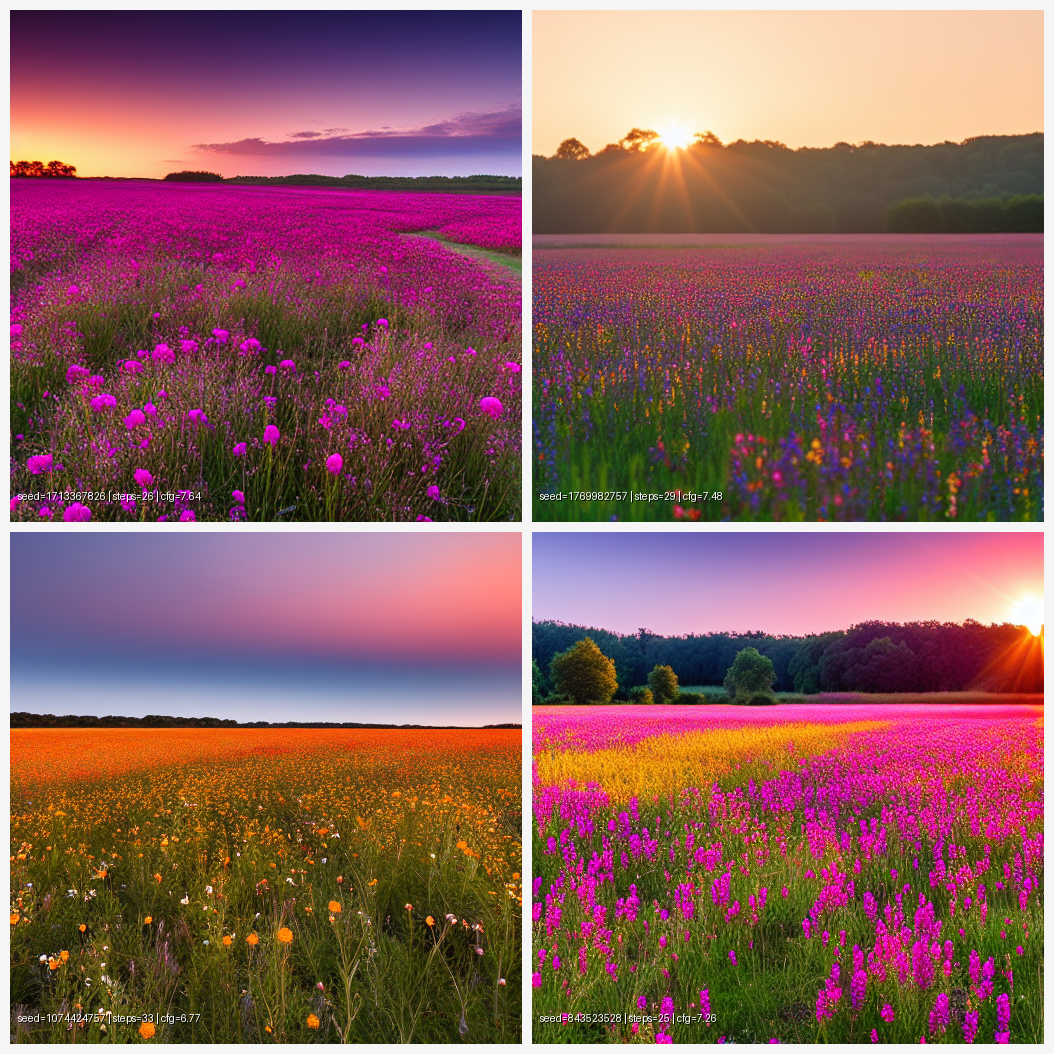

**Grid guardado en:** `/content/outputs/sd_20251107_192334_grid.png`

In [16]:
grid = image_grid(images, rows=ROWS, cols=COLS, padding=10, bg=(245,245,245))
grid_path = os.path.join(OUTDIR, f"{prefix}_grid.png")
grid.save(grid_path)

# Queremos mostrar el colab en el notebook:
from IPython.display import display, Markdown
display(grid)
display(Markdown(f"**Grid guardado en:** `{grid_path}`"))

Guardamos los metadatos

In [17]:
meta = {
    "prompt": PROMPT,
    "negative_prompt": NEGATIVE,
    "model_id": MODEL_ID,
    "device": device,
    "dtype": "float16" if (device=="cuda") else "float32",
    "seed_base": SEED_BASE,
    "images": meta_per_image,
}
with open(os.path.join(OUTDIR, f"{prefix}_meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ Generación completada")
print("Grid:", grid_path)
for i in range(NUM_IMAGES):
    print("Tile:", os.path.join(OUTDIR, f"{prefix}_{i+1:02d}.png"))

✅ Generación completada
Grid: /content/outputs/sd_20251107_192334_grid.png
Tile: /content/outputs/sd_20251107_192334_01.png
Tile: /content/outputs/sd_20251107_192334_02.png
Tile: /content/outputs/sd_20251107_192334_03.png
Tile: /content/outputs/sd_20251107_192334_04.png
